# Проект №1: "Исследование надёжности заёмщиков"

## Описание:
* Заказчик — кредитный отдел банка
* Данные - статистика о платёжеспособности клиентов

## Признаки:
|признак|описание|тип признака|
|---|---|---|
|children|количество детей в семье|признак|
|days_employed|общий трудовой стаж в днях|признак|
|dob_years|возраст клиента в годах|признак|
|education|уровень образования клиента|признак|
|education_id|идентификатор уровня образования|признак|
|family_status|семейное положение|признак|
|family_status_id|идентификатор семейного положения|признак|
|gender — пол|клиента|признак|
|income_type|тип занятости|признак|
|total_income|ежемесячный доход|признак|
|purpose|цель получения кредита|признак|
|debt|имел ли задолженность по возврату кредитов|целевой признак|


## Цель:
разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок.

## Содержание:

1. [Загрузка данных](#1)
2. [Предобработка данных](#2)

    2.1 [Определение и заполнение пропущенных значений](#2.1)    
    2.2 [Замена вещественного тип данных на целочисленный](#2.2)    
    2.3 [Удаление дубликатов](#2.3)    
    2.4 [Выделение леммы в значениях столбца с целями получения кредита](#2.4)    
    2.5 [Категоризация данных](#2.5)
    
3. [Ответы на вопросы](#3)

## 1. Откройте таблицу и изучите общую информацию о данных

In [438]:
import pandas as pd
import numpy as np

from pymystem3 import Mystem
from nltk.stem import SnowballStemmer 

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook
from tabulate import tabulate

In [439]:
df = pd.read_csv('datasets/data.csv')

In [440]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


### 1.1 Общая информация

In [441]:
global_info = []
for col in df.columns:
    values = df[col]
    mn, mx = values.min(), values.max()
    if (isinstance(mn, (int,float))) and (isinstance(mx, (int,float))):
        global_info.append([col,values.dtype, values.nunique(), mn, mx])
    else:
        global_info.append([col,values.dtype, values.nunique(), np.nan, np.nan])

In [442]:
print(tabulate(global_info, headers=['Имя', 'Тип', 'Число уникальных значений', 'Минимум', 'Максимум']))

Имя               Тип        Число уникальных значений    Минимум         Максимум
----------------  -------  ---------------------------  ---------  ---------------
children          int64                              8       -1        20
days_employed     float64                        19351   -18388.9  401755
dob_years         int64                             58        0        75
education         object                            15      nan       nan
education_id      int64                              5        0         4
family_status     object                             5      nan       nan
family_status_id  int64                              5        0         4
gender            object                             3      nan       nan
income_type       object                             8      nan       nan
debt              int64                              2        0         1
total_income      float64                        19351    20667.3       2.2656e+06
purpose    

% отрицательных зачений в столбце days_employed равен 73.9%
Минимум, максимум для отрицательных значений: 328728.72 401755.40
Минимум, максимум для положительных значений: 24.14 18388.95


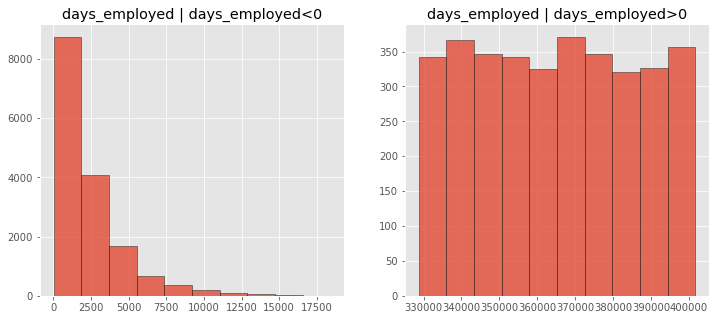

In [443]:
feat = 'days_employed'
negative_days_employed = df[feat] < 0

print('% отрицательных зачений в столбце {} равен {:.1%}'.format(feat, (df[feat] < 0).mean()))
print('Минимум, максимум для отрицательных значений: {:.2f} {:.2f}'.format((df[feat][df[feat] > 0]).min(), df[feat][df[feat] > 0].max()))
print('Минимум, максимум для положительных значений: {:.2f} {:.2f}'.format(df[feat][df[feat] < 0].abs().min(), df[feat][df[feat] < 0].abs().max()))

plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
df[negative_days_employed][feat].abs().hist(edgecolor = 'black', alpha = .8)
plt.title(feat+' | days_employed<0')

plt.subplot(1, 2, 2)
df[~negative_days_employed][feat].abs().hist(edgecolor = 'black', alpha = .8)
plt.title(feat+' | days_employed>0')

plt.show()

## Шаг 2. Предобработка данных

##### days_employed - трудовой стаж
* _трудовой стаж, имеющий отрицательные значения распределен логнормально, что говорит об адектватности значений. Все отрицательные значения возьмем по модулю_
* _положительные значения распределены равномерно. это говорит о том, что данные значения принадлежат похожим людям_
* _заметим, что масшатбы значений в данных группах разные (одни измерены в днях, другие - в часах)_
* _все стажи, имющие значение в годах больше 100, поделим на 24_

In [444]:
df['days_employed'] = df['days_employed'].abs().apply(lambda x: x if (x/365.25 < 100) else x/24) 

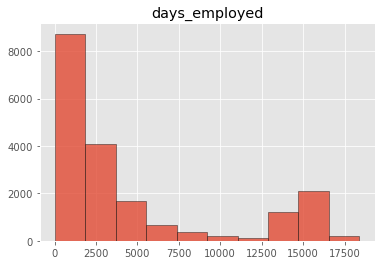

In [445]:
df['days_employed'].hist(edgecolor = 'black', alpha = .8)
plt.title('days_employed')
plt.show()

In [446]:
for k, v in (df['days_employed'] // 365.25).agg({'min', 'max'}).items():
    print('days_employed | {} == {}'.format(k, v))

days_employed | max == 50.0
days_employed | min == 0.0


##### Работать можно с 14 лет, проверим, все ли рабочие стажи этому соответствуют

In [447]:
df['years_employed'] = df['days_employed'] // 365.25
mask = (df['dob_years']!=0) & (df['years_employed'].notna()) & (df['years_employed']  >= (df['dob_years']-14))
for k, v in df[mask]['income_type'].value_counts().items():
    print('Возраст и трудовой стаж не соответствуют трудовому законодательству у {} {} из {}'\
          .format(v, k, (df['income_type'] == k).sum()))

Возраст и трудовой стаж не соответствуют трудовому законодательству у 872 пенсионер из 3856
Возраст и трудовой стаж не соответствуют трудовому законодательству у 10 сотрудник из 11119
Возраст и трудовой стаж не соответствуют трудовому законодательству у 4 компаньон из 5085
Возраст и трудовой стаж не соответствуют трудовому законодательству у 2 безработный из 2
Возраст и трудовой стаж не соответствуют трудовому законодательству у 1 госслужащий из 1459


##### У 872 пенсионеров рабочий стаж и возраст не соотвествуют законодательсву, исправим стаж на средний по группировке возраста и типа дохода

In [448]:
grouped_by_dob_years_and_income_type = df[~mask].groupby(['dob_years', 'income_type'])['days_employed'].mean().reset_index()

In [449]:
grouped_by_dob_years_and_income_type = grouped_by_dob_years_and_income_type[grouped_by_dob_years_and_income_type['income_type'] != 'безработный']

In [450]:
for i in df[mask].index:
    row = df.loc[i]
    if ~np.isnan(row['days_employed']) and ~np.isnan(row['total_income']):
        df.loc[i, 'days_employed'] = \
        grouped_by_dob_years_and_income_type[grouped_by_dob_years_and_income_type['income_type'] == row['income_type']]\
        ['days_employed'].mean()

In [451]:
df.loc[df['income_type'] == 'безработный', 'days_employed'] = df[df['income_type'] != 'безработный']['days_employed'].mean()

In [452]:
print('Возраст и трудовой стаж не соответствуют трудовому законодательству {} '\
      .format(((df['dob_years']!=0) & (df['years_employed'].notna()) & (df['years_employed']  >= (df['dob_years']-14))).all()))
df = df.drop('years_employed', 1)

Возраст и трудовой стаж не соответствуют трудовому законодательству False 


In [453]:
def show_categories_distribution(df, feat):
    info = []
    for key, value in df[feat].value_counts().sort_index().items():
        info.append((key, value))  

    print('признак: {}         \n'.format(feat))
    print(tabulate(info, headers=['группа', 'размер группы']))

In [454]:
for feat in ['children', 'dob_years', 'education', 'education_id',
             'family_status', 'family_status_id', 'gender', 'income_type', 'purpose']:
    show_categories_distribution(df, feat)
    print('\n#############################################\n')

признак: children         

  группа    размер группы
--------  ---------------
      -1               47
       0            14149
       1             4818
       2             2055
       3              330
       4               41
       5                9
      20               76

#############################################

признак: dob_years         

  группа    размер группы
--------  ---------------
       0              101
      19               14
      20               51
      21              111
      22              183
      23              254
      24              264
      25              357
      26              408
      27              493
      28              503
      29              545
      30              540
      31              560
      32              510
      33              581
      34              603
      35              617
      36              555
      37              537
      38              598
      39              573
      40   

##### Значения в children, dob_years, gender заменим на типичные значения для людей с подобным уровнем дохода

* _total_income  (доход распределен логнормально, как и должно быть)_  
* _children - странные значения -1, 20_
* _dob_years - странное значение 0_
* _gender - странное значение XNA_

In [455]:
for by, to_estimate, values in zip(('children', 'dob_years', 'gender'),
                                    ('total_income', 'total_income', 'total_income'),
                                    ([-1, 20], [0], ['XNA'])):
    try:
        grouped = df.groupby(by)[to_estimate].mean()
    except:
        grouped = df.groupby(by)[to_estimate].value_counts()        
    g_ok = grouped.drop(values)
    g_notok = grouped[values]
    for val, g in zip(values, g_notok.index):
        replacement = g_ok.index[np.argmin(np.abs(g_ok - g_notok[val]))]
        df.loc[df[by] == val, by] =  replacement
        print('В {} заменяем {} по {} значением {}'.format(by, val, to_estimate, replacement))

В children заменяем -1 по total_income значением 0
В children заменяем 20 по total_income значением 5
В dob_years заменяем 0 по total_income значением 26
В gender заменяем XNA по total_income значением M


### 2.1 Определите и заполните пропущенные значения:

* пропусков около 10%
* пропуски находятся в идентичных строках
* в столбцах days_employed, total_income
* пропуски могли появиться из-за ошибки в сборе инфорамции
* заполним пропуски средним по типу занятости

In [456]:
df.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

In [457]:
print('% строк с пропусками равен {:.2%}'.format(df.isna().any(1).mean()))
print('значения пропущены в  {}'.format(df.columns[df.isna().any()].tolist()))
print('Значения пропущены в идентичных строках: {}'.format((df['days_employed'].isna() == df['total_income'].isna()).all()))

% строк с пропусками равен 10.10%
значения пропущены в  ['days_employed', 'total_income']
Значения пропущены в идентичных строках: True


In [458]:
means_by_income_type = df.groupby('income_type')[['days_employed', 'total_income']].mean()

In [459]:
means_by_income_type

,days_employed,total_income
income_type,,
безработный,4604.976161,131339.751676
в декрете,3296.759962,53829.130729
госслужащий,3390.996085,170898.309923
компаньон,2103.416611,202417.461462
пенсионер,15048.905858,137127.465690
предприниматель,520.848083,499163.144947
сотрудник,2317.513463,161380.260488
студент,578.751554,98201.625314


In [460]:
for i in df[df['days_employed'].isna()].index:
    row = df.loc[i]    
    df.loc[i, ['days_employed', 'total_income']] = means_by_income_type.loc[row['income_type']]

In [461]:
print('Есть пропуски: {}'.format(df.isna().any().any()))

Есть пропуски: False


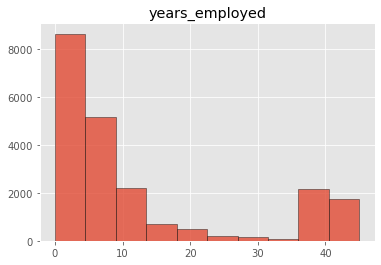

In [462]:
(df['days_employed'] // 365.25).hist(edgecolor = 'black', alpha = .8)
plt.title('years_employed');

### 2.2 Замените вещественный тип данных на целочисленный
* выбираем вещественные колонки с помощью .select_dtypes()
* округляем .round()
* приводим к типу int .astype()

In [463]:
for col in df.select_dtypes(exclude = ['object']).columns:
    df[col] = df[col].round().astype(int)

In [464]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21525 non-null  int32 
 1   days_employed     21525 non-null  int32 
 2   dob_years         21525 non-null  int32 
 3   education         21525 non-null  object
 4   education_id      21525 non-null  int32 
 5   family_status     21525 non-null  object
 6   family_status_id  21525 non-null  int32 
 7   gender            21525 non-null  object
 8   income_type       21525 non-null  object
 9   debt              21525 non-null  int32 
 10  total_income      21525 non-null  int32 
 11  purpose           21525 non-null  object
dtypes: int32(7), object(5)
memory usage: 1.4+ MB


### 2.3 Удалите дубликаты
* все строки приводим к нижнему регистру, удаляем пропуски в начале и конце строк: .str.strip(), .str.lower()
* ищем дублирующиеся строки с помощью .duplicated()
* удаляем дубликаты с помощью .drop_duplicates()
* дубликаты могли появиться, если данные выгружались из разных таблиц БД с помощью внешнего джойна

In [465]:
for col in df.select_dtypes(object).columns:
    df[col] = df[col].str.strip().str.lower()
print('распределения в education и education_id одинаковые : {}'\
      .format(set(df['education'].value_counts().values) == set(df['education_id'].value_counts().values)))
print('распределения в family_status и family_status_id одинаковые : {}'
      .format(set(df['family_status'].value_counts().values) == set(df['family_status_id'].value_counts().values)))
print('% дублирующихся строк равен {:.2%}'.format(df.duplicated().mean()))

распределения в education и education_id одинаковые : True
распределения в family_status и family_status_id одинаковые : True
% дублирующихся строк равен 0.33%


In [466]:
df = df.drop_duplicates()

In [467]:
df['gender'] = df['gender'].map({'f' : 'ж', 'm' : 'м'})

### 2.4 Выделите леммы в значениях столбца с целями получения кредита
* чтобы быстрее провести лемматизацию, делаем n_iterations бутстреп подвыборок размером n_samples
* лемматизируем столбец с целью кредита с помощью Mystem() (.lemmatize())
* далее делаем стемминг с помощью SnowbalSteamer(), чтобы выделить более общие группы
* добавляем полученные строки в список
* посчитаем количества каждого слова в полученном списке
* выделим топ слов и выявим основные группы целей

In [468]:
def _get_top_lemmas(series, n_iterations, n_samples):
    '''    
    n_iteraions раз семплирует строки по n_samples, лемматизирует      
    '''
    m = Mystem()    
    list_of_lemmas = []
    # итерируемся
    for seed in tqdm_notebook(range(n_iterations)):
        # фиксируем сид
        np.random.seed(seed)
        # семплируем
        idxs_subset = np.random.choice(np.arange(len(series)), n_samples)
        sample = series.iloc[idxs_subset]
        # по строкам
        for element in sample:
            # лемматизируем
            lemmas = m.lemmatize(element)
            # добавляем к списку лемм
            list_of_lemmas.extend(lemmas)
    # применяем стемминг
    russian_stemmer = SnowballStemmer('russian')  
    lemmas_counts = pd.Series([russian_stemmer.stem(word) for word in list_of_lemmas]).value_counts()
    return lemmas_counts

In [469]:
lemmas_counts = _get_top_lemmas(df['purpose'], n_iterations=100, n_samples=5)

In [470]:
print('Самые популярные леммы (группа лемм, чья длина меньше 3 не учитывалась) :\n----------------------------------------')
for k, v in lemmas_counts.items():
    if len(k.strip())>=3:
        print('лемма == {} | кол-во равно {}'.format(k, v))
print('----------------------------------------')
print('Выделим такие группы: жилье, недвижимость, образование, автомобиль, свадьба')
print('Создадим словарь для замены')
purposes_dict = {'жил':'жилье', 'недвижим' :'недвижимость', 'образован' : 'образование', 'автомобил':'автомобиль', 'свадьб ':'свадьба'}
print('Заменим исходные цели на выявленные категории')
for key, value in purposes_dict.items():    
    df.loc[df['purpose'].str.contains(key), 'purpose_cat'] = value

Самые популярные леммы (группа лемм, чья длина меньше 3 не учитывалась) :
----------------------------------------
лемма == недвижим | кол-во равно 131
лемма == покупк | кол-во равно 130
лемма == жил | кол-во равно 127
лемма == образован | кол-во равно 117
лемма == автомобил | кол-во равно 109
лемма == операц | кол-во равно 54
лемма == свадьб | кол-во равно 43
лемма == сво | кол-во равно 42
лемма == строительств | кол-во равно 38
лемма == получен | кол-во равно 37
лемма == высок | кол-во равно 37
лемма == подержа | кол-во равно 35
лемма == коммерческ | кол-во равно 29
лемма == для | кол-во равно 26
лемма == сделк | кол-во равно 26
лемма == занима | кол-во равно 23
лемма == дополнительн | кол-во равно 19
лемма == профильн | кол-во равно 19
лемма == ремонт | кол-во равно 17
лемма == сдач | кол-во равно 16
лемма == сыгра | кол-во равно 16
лемма == проведен | кол-во равно 15
лемма == приобретен | кол-во равно 14
лемма == сем | кол-во равно 10
лемма == собствен | кол-во равно 9
------------

### 2.5 категоризируйте данные:
* клипируем значения колонки
* с помощью np.histogram получим гистограмму
* с помощью l1 нормы определим, к какому из бинов каждое значение ближе 
* факторизуем получившийся индекс 

In [471]:
def _show_categories(df, feat):
    print('----------Категоризация {}----------'.format(feat))
    for k, v in df[feat].value_counts().items():
        print('категория == {}, размер категории == {}'.format(k, v))    

In [472]:
for col in ['children', 'days_employed', 'total_income', 'dob_years']:
    new_col = col+'_cat'
    values = df[col]
    # клипируем значения
    val_clipped = values.clip(values.quantile(.025), values.quantile(.975))
    # строим гистограмму
    bins = np.histogram(val_clipped)[1]
    # определяем ближайший бин, факторизуем
    df[new_col] = val_clipped.apply(lambda x: np.abs(x- bins).argmin())
    # среднее значение показаеля по лейблам, сортируем
    mean_by_label_sorted = df.groupby(new_col)[col].mean().sort_values()
    # ранжируем показатель
    d = dict(zip(mean_by_label_sorted.index, range(len(mean_by_label_sorted))))
    # обновляем лейбл (ставим лейбл в соответствии с средним значением в категории)
    df[new_col] = df[new_col].map(d)            
    # распределение категорий
    _show_categories(df, new_col)

----------Категоризация children_cat----------
категория == 0, размер категории == 14138
категория == 1, размер категории == 4808
категория == 2, размер категории == 2508
----------Категоризация days_employed_cat----------
категория == 1, размер категории == 7109
категория == 0, размер категории == 5030
категория == 2, размер категории == 2909
категория == 9, размер категории == 2648
категория == 3, размер категории == 1269
категория == 10, размер категории == 1215
категория == 4, размер категории == 554
категория == 5, размер категории == 349
категория == 6, размер категории == 195
категория == 7, размер категории == 124
категория == 8, размер категории == 52
----------Категоризация total_income_cat----------
категория == 3, размер категории == 4633
категория == 2, размер категории == 4342
категория == 1, размер категории == 3587
категория == 4, размер категории == 2753
категория == 0, размер категории == 1590
категория == 5, размер категории == 1538
категория == 6, размер категории =

In [473]:
for col1, col2 in zip(['children', 'days_employed', 'total_income', 'dob_years'],\
                      ['children_cat', 'days_employed_cat', 'total_income_cat', 'dob_years_cat']):
    grouped_means = df.groupby(col2)[col1].mean().sort_values()
    print('-----------------------------------------------------')
    for k, v in grouped_means.items():
        print('признак == {}, категория == {}, среднее значение == {}'.format(col2, k, v))

-----------------------------------------------------
признак == children_cat, категория == 0, среднее значение == 0.0
признак == children_cat, категория == 1, среднее значение == 1.0
признак == children_cat, категория == 2, среднее значение == 2.2659489633173844
-----------------------------------------------------
признак == days_employed_cat, категория == 0, среднее значение == 498.2924453280318
признак == days_employed_cat, категория == 1, среднее значение == 1775.5757490504993
признак == days_employed_cat, категория == 2, среднее значение == 3216.325197662427
признак == days_employed_cat, категория == 3, среднее значение == 4802.835303388495
признак == days_employed_cat, категория == 4, среднее значение == 6400.667870036101
признак == days_employed_cat, категория == 5, среднее значение == 7988.372492836676
признак == days_employed_cat, категория == 6, среднее значение == 9573.117948717949
признак == days_employed_cat, категория == 7, среднее значение == 11193.290322580646
признак 

#### Заменим лейблы категорий на округленное среднее значение показателя в категории (дни переведем в годы)

In [474]:
for col in ['days_employed', 'total_income']:
    df[col+'_cat'] = df[col+'_cat']\
                              .map((df.groupby(col+'_cat')[col].mean() // 365.25).astype(int))
df['dob_years_cat'] = df['dob_years_cat'].map(df.groupby('dob_years_cat')['dob_years'].mean().round().astype(int))

In [475]:
print('Группы категорий')
for col1, col2 in zip(['children', 'days_employed', 'total_income', 'dob_years'],\
                      ['children_cat', 'days_employed_cat', 'total_income_cat', 'dob_years_cat']):
    grouped_means = df.groupby(col2)[col1].mean().sort_values()
    print('-----------------------------------------------------')
    for k, v in grouped_means.items():
        print('признак == {}, категория == {}, среднее значение == {}'.format(col2, k, v))

Группы категорий
-----------------------------------------------------
признак == children_cat, категория == 0, среднее значение == 0.0
признак == children_cat, категория == 1, среднее значение == 1.0
признак == children_cat, категория == 2, среднее значение == 2.2659489633173844
-----------------------------------------------------
признак == days_employed_cat, категория == 1, среднее значение == 498.2924453280318
признак == days_employed_cat, категория == 4, среднее значение == 1775.5757490504993
признак == days_employed_cat, категория == 8, среднее значение == 3216.325197662427
признак == days_employed_cat, категория == 13, среднее значение == 4802.835303388495
признак == days_employed_cat, категория == 17, среднее значение == 6400.667870036101
признак == days_employed_cat, категория == 21, среднее значение == 7988.372492836676
признак == days_employed_cat, категория == 26, среднее значение == 9573.117948717949
признак == days_employed_cat, категория == 30, среднее значение == 11193

#### _выделились следующие группы_
* _children, группы: нет детей, 1 ребенок, детей 2+_
* _days_employed, средний стаж в годах: 1, 4, 8, 13, 17, 21, 26, 30, 34, 40, 43_ 
* _total_income, средний доход в тыс.руб.: 157, 246, 339, 433, 528, 616, 711, 801, 900, 993, 1433_
* _dob_years_cat, средний возраст : 23, 28, 32, 36, 41, 44, 49, 53, 57, 61, 67_

## Шаг 3. Ответьте на вопросы

##### Q1. Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [565]:
q1_df = df.groupby('children_cat')[['children', 'debt']].mean().add_suffix('_mean').reset_index()
q1_df['debt_mean, %'] = q1_df['debt_mean'].apply(lambda x: str(round(x*100, 2))+'%')
q1_df = q1_df.drop('debt_mean', 1)
q1_df = q1_df.join(df.groupby('children_cat').size().to_frame('size')).round(2)
q1_df = q1_df.sort_values('debt_mean, %')
q1_df.columns = ['Категория', 'Среднее число детей', 'Средний % просрочки', 'Размер группы'] 

In [566]:
q1_df

,Категория,Среднее число детей,Средний % просрочки,Размер группы
0,0,0.00,7.53%,14138
1,1,1.00,9.23%,4808
2,2,2.27,9.29%,2508


##### A1. Полученные расчеты позволяют нам с уверенностью сказать, что те заемщики, которые не имеют детей, реже других попадают в статус "просрочка". Однако и говорить о том , что с ростом числа детей, растет процент просрочки было бы не совсем корректно т.к. у заемщиков с 3-мя детьми мы видим относительно хорошие показатели на уровне 8.2% , что сопоставимо со средним процентом просрочки по всем, а заемщиков с 5-ю детьми и вовсе слишком мало. Ответ на вопрос о взаимосвязи наличия детей и возврата кредита в срок однозначно положительный, но всякий раз стоит смотреть именно на количество.

#### _Q2. Есть ли зависимость между семейным положением и возвратом кредита в срок?_

In [563]:
q2_df = df.groupby('family_status')['debt'].agg({'mean', 'count'}).reset_index()
q2_df['debt_mean, %'] = (q2_df['mean']* 100).round(2).astype(str) + '%'
q2_df = q2_df.rename(columns ={'count': 'debt_count'}).drop('mean', 1)
q2_df = q2_df.sort_values('debt_mean, %')
q2_df.columns = ['Семейное положение', 'Размер группы', 'Средний % просрочки']

In [564]:
q2_df

,Семейное положение,Размер группы,Средний % просрочки
1,вдовец / вдова,959,6.57%
0,в разводе,1195,7.11%
3,женат / замужем,12339,7.55%
2,гражданский брак,4151,9.35%
4,не женат / не замужем,2810,9.75%


##### A2. Полученные расчеты позволяют нам с уверенностью сказать, что заемщики-вдовы, заемщики-вдовцы реже всего просрачивают средит : % просрочек равен 6.57%, сопоставимые показатели имеют люди в разводе и женатые люди: 7.11% и 7.55% соответственно. также сопоставимы проценты просрочки у людей в гражданском браке и не женатых людей. составляют 9.35%, 9.75% соответственно.

#### _Q3. Есть ли зависимость между уровнем дохода и возвратом кредита в срок?_

In [558]:
q3_df = ((df.groupby('total_income_cat')['total_income'].mean()//1000).to_frame('Средний доход, тыс.р.')\
    .join(df.groupby('total_income_cat')['debt'].mean().mul(100).round(1).to_frame('Средний % просрочки')))
q3_df['Размер группы'] = df.groupby('total_income_cat').size()
q3_df = q3_df.sort_values('Средний % просрочки')
q3_df['Кластер'] = q3_df['Средний % просрочки'].round().factorize()[0]
q3_df

,"Средний доход, тыс.р.",Средний % просрочки,Размер группы,Кластер
total_income_cat,,,,
1433,523.0,5.9,631,0
711,260.0,6.6,1070,1
157,57.0,6.9,1590,1
801,292.0,6.9,621,1
616,225.0,7.5,1538,2
900,328.0,7.9,416,2
528,193.0,8.0,2753,2
993,362.0,8.1,273,2
246,89.0,8.3,3587,2


#### _A3. Полученные расчеты позволяют нам с уверенностью сказать, что по зависимости % просрочек от уровня дохода заемщиков можно разделить на 4 группы:_
* самые надежные - средний ежемесячный доход равен 524 тыс.руб., 259 тыс.руб. с % просрочек 5.9%, 6.5%
* менее надежные - средний ежемесячный доход равен 57 тыс.руб., 292 тыс.руб., 225 тыс.руб. с % просрочек 6.8%, 6.9%, 7.1%
* еще менее надежные - средний ежемесячный доход равен 190 тыс.руб., 329 тыс.руб., 363 тыс.руб., 90.0 тыс.руб.  с % просрочек 7.9%, 7.9%, 8.1%, 8.3%
* наименее надежные - средний ежемесячный доход равен 123 тыс.руб., 156 тыс.руб. с % просрочек 8.8%, 9.3%

#### _Можно утвержать, что люди с доходом более 500 тыс.руб.в месяц являются наиболее надежными заемщиками.Также видно, что люди с доходом около 150 тыс.руб. чаще всего просрачивают средит. Видно, что вцелом ,размер дохода не очень хорошо отражает надежность заемщика.он является весомым фактором, но не решающим_

#### _Q4. Как разные цели кредита влияют на его возврат в срок?_

In [561]:
q4_df = df.groupby('purpose_cat')['debt'].agg({'mean', 'count'}).reset_index()
q4_df['mean'] = (q4_df['mean'] * 100).round(2).astype(str) +'%'
q4_df.columns = ['Цель кредита', 'Размер группы', 'Средний % просрочки']

In [562]:
q4_df

,Цель кредита,Размер группы,Средний % просрочки
0,автомобиль,4306,9.36%
1,жилье,4460,6.91%
2,недвижимость,6351,7.46%
3,образование,4013,9.22%


##### A4. Можно утвержать, что заемщики с кредитами на автомобиль - самые ненадежные (9.36% просрочек), а на жилье - самые надежные (6.9% просрочек). Видно, что люди лучше готовы к дорогим кредитам (жалье, недвижимость), потому что понимают ответственность и лучше обдумывают решение, образование и автомобиль - сопоставимы по риску: 9.2%, 9.3%¶

#### % просрочки кредита по целям и категориям

In [708]:
report_df = pd.DataFrame()
for col in ['education', 'family_status', 'purpose_cat', 'children_cat', 'days_employed_cat', 'total_income_cat', 'dob_years_cat']:
    for unique_value in df[col].unique():
        colname = '{} == {}'.format(col, unique_value)
        try:
            mean_grp_val = df[df[col] == unique_value][col[:-4]].mean()        
        except:
            mean_grp_val = unique_value       
        val = df[df[col] == unique_value]['debt'].mean()
        if ~np.isnan(val):
            if col not in ('education', 'family_status'):
                report_df.loc[colname, 'Показатель'] = col[:-4]
            else:
                report_df.loc[colname, 'Показатель'] = col              
            report_df.loc[colname, 'Задолженность, %'] = round(val * 100, 2)
            try:
                report_df.loc[colname, 'Среднее значение в группе'] = round(mean_grp_val, 2)
            except:
                report_df.loc[colname, 'Среднее значение в группе'] = mean_grp_val                
report_df = report_df.sort_values('Задолженность, %', ascending = False)        

In [709]:
report_df

,Показатель,"Задолженность, %",Среднее значение в группе
days_employed_cat == 1,days_employed,11.13,498.29
dob_years_cat == 28,dob_years,11.03,27.53
education == начальное,education,10.99,начальное
dob_years_cat == 32,dob_years,10.89,31.52
dob_years_cat == 23,dob_years,10.63,23.3
family_status == не женат / не замужем,family_status,9.75,не женат / не замужем
purpose_cat == автомобиль,purpose,9.36,автомобиль
family_status == гражданский брак,family_status,9.35,гражданский брак
dob_years_cat == 36,dob_years,9.30,35.97
children_cat == 2,children,9.29,2.27


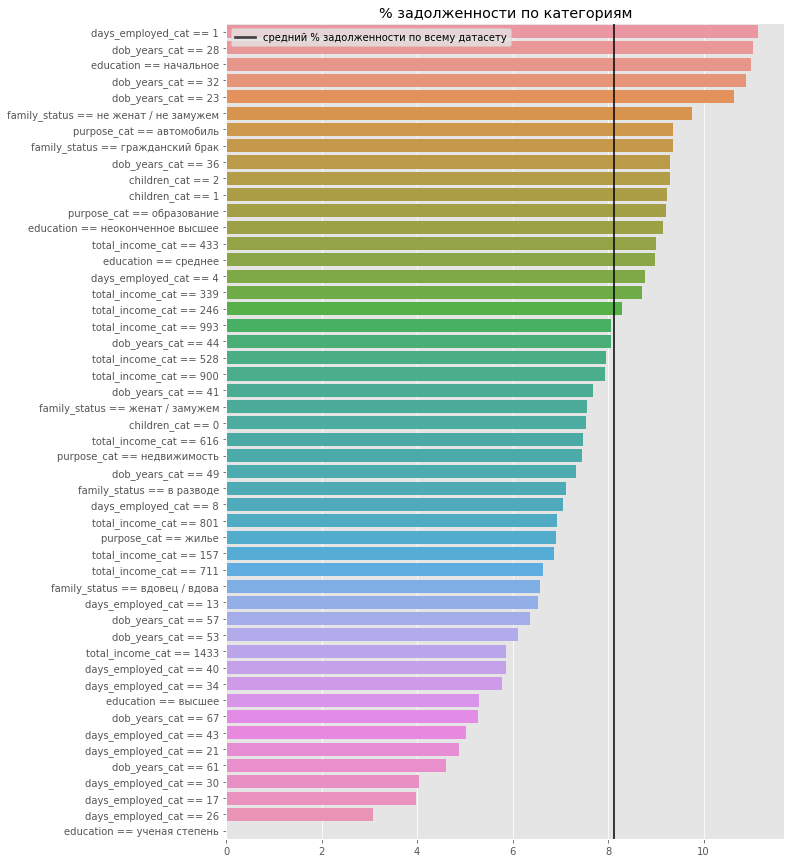

In [710]:
series = report_df['Задолженность, %']
plt.figure(figsize = (10, 15))
sns.barplot(x = series.values, y = series.index)
plt.axvline(df['debt'].mean()*100, color = 'black')
plt.legend(['средний % задолженности'], loc = 'upper left')
plt.title('% задолженности по категориям')
plt.show()

### _Выводы:_

##### _1) целью проекта являлось исследование надежности заемщика по следующим характеристикам:_
* _children - число детей_
* _days_employed - трудовой стаж_
* _dob_years - возраст_
* _education, education_id - образование_
* _family, family_status - семеное положение_
* _gender - пол_
* _income_type - тип дохода_
* _pupose - цель кредита_

##### 2) _В данных имелись значения, требовавшие корректировки:_
* _Дубликаты строк: могли появиться при выгрузке данных из БД. Дубликаты были удалены_
* _Присутствовали странные значения: для числа детей -1, 20; для пола: XNA, для возраста - 0. Эти значения были заменены значениями людей, имеющих тот же уровень дохода_
* _Поле days_employed содержало отрицательные значения, а так же аномально большие значения. Похоже, некоторые строки измерялись в днях, а некоторые - в часах. Значения были исправлены. Также в колонках days_employed, total_income присутствовали пропуски значений в идентичных строках. Пропуски были заполнены средним значением показатьеля, сгруппированного по типу дохода income_type_

##### 3) _Наиболее рискованными являются следующие группы заемщиков:_

|Группа|Показатель|Задолженность, %|Среднее значение в группе (в годах)|
|------|------|------|------|
|days_employed_cat == 1|days_employed|11.13|1.36|
|dob_years_cat == 28|days_employed|11.13|27.53|
|education == начальное|education|10.99|начальное|
|dob_years_cat == 32|dob_years|10.89|31|
|dob_years_cat == 23|dob_years|10.63|23|

##### 4) _Было выявлено, что наиболее плохими заемщиками являются люди с рабочим стажем меньше 2 лет, в возрасте около 28 лет,  с начальным образованием. Это логично, потому что люди с начальным образованием в возрасте 27 лет могли работать с 19(после армии). Заемщик, проработавший не больше 2 лет в период с 19 до 27 лет явно является наименее надежным_